# Sourcing & Analyzing Time-Series Data

### Contents:

#### 1. Importing libraries and data
#### 2. Subsetting, wrangling, and cleaning time-series data
#### 3. Time series analysis: decomposition
#### 4. Stationarizing the data

### 1.0 Importing your libraries and data

In [15]:
import quandl
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import statsmodels.api as sm 
import os
import warnings 

# Disable deprecation warnings 
warnings.filterwarnings("ignore")

# Style for plots
plt.style.use('fivethirtyeight')

In [16]:
# Configure API key 
quandl.ApiConfig.api_key = 'r8kfPxqsghpTLz1h4eXK'

In [17]:
# Importing the Federal Reserve Economic Data "Natural Rate of Unemployment" variable
# For use as comparison for gun incidents are related to rate of unemployment
data = quandl.get('FRED/NROUST')

In [44]:
data.head()

,Value
Date,
1949-01-01,5.255053
1949-04-01,5.261516
1949-07-01,5.268013
1949-10-01,5.274564
1950-01-01,5.281182


In [45]:
data.shape

(332, 1)

In [20]:
data.columns

Index(['Value'], dtype='object')

In [21]:
type(data)

pandas.core.frame.DataFrame

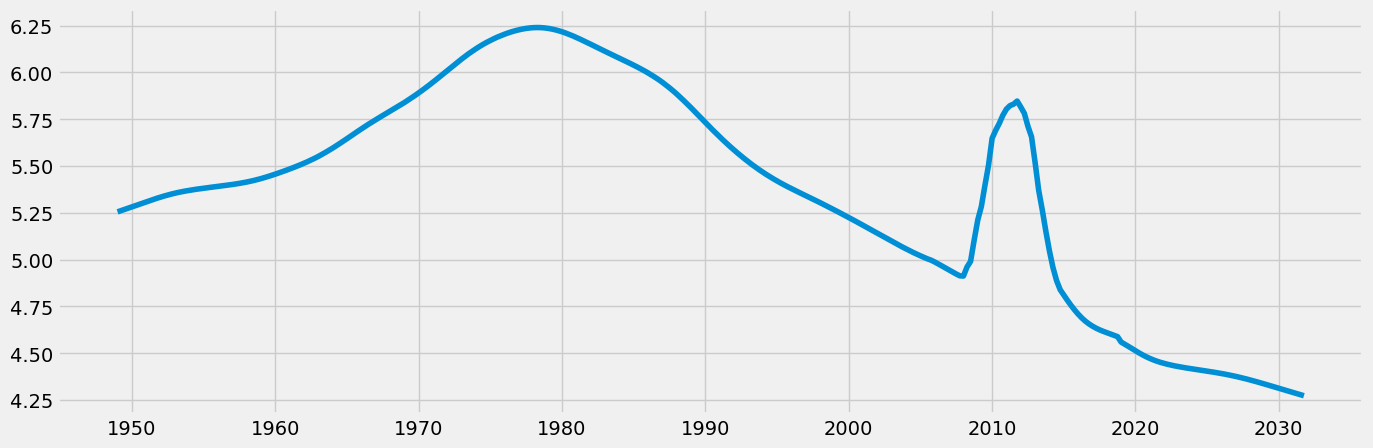

In [22]:
# Plot the data using matplotlib.
plt.figure(figsize=(15,5), dpi=100) 
plt.plot(data)

### 2.0 Subsetting, wrangling, and cleaning time-series data

In [23]:
# Reset index to filter date to match gun violence dates
data_2 = data.reset_index()

In [24]:
data_2.head()

,Date,Value
0,1949-01-01,5.255053
1,1949-04-01,5.261516
2,1949-07-01,5.268013
3,1949-10-01,5.274564
4,1950-01-01,5.281182


In [25]:
data_sub = data_2.loc[(data_2['Date'] >= '2013-01-01') & (data_2['Date'] < '2023-08-01')]

In [26]:
data_sub.shape

(43, 2)

In [27]:
data_sub.head()

,Date,Value
256,2013-01-01,5.516897
257,2013-04-01,5.370587
258,2013-07-01,5.265987
259,2013-10-01,5.150994
260,2014-01-01,5.045110


In [28]:
# Set date as index column for plotting
from datetime import datetime

#Create datetime column
data_sub['datetime'] = pd.to_datetime(data_sub['Date']) 
# Set the datetime as the index
data_sub = data_sub.set_index('datetime') # Set the datetime as the index of the dataframe.
# Drop Date column so datetime column can act as index
data_sub.drop(['Date'], axis=1, inplace=True) 
data_sub.head()

,Value
datetime,
2013-01-01,5.516897
2013-04-01,5.370587
2013-07-01,5.265987
2013-10-01,5.150994
2014-01-01,5.045110


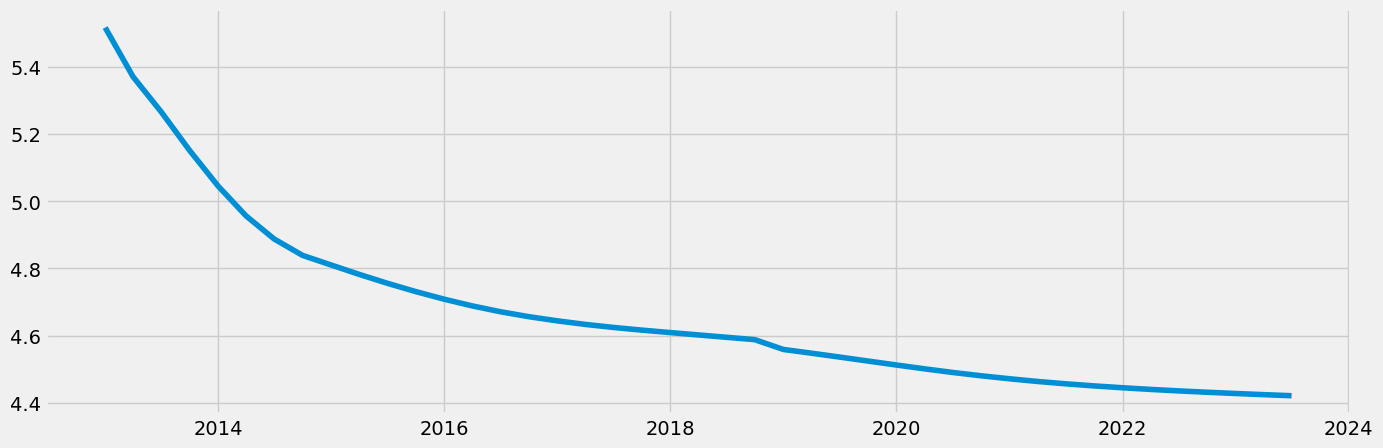

In [29]:
# Plot the new data set
plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_sub)

In [30]:
# Check for missing values (you shouldn't have any)
data_sub.isnull().sum() 

Value    0
dtype: int64

In [31]:
# Check for duplicates
dups = data_sub.duplicated()
dups.sum()


0

### 3.0 Time-series analysis: decomposition

In [32]:
# Decompose the time series using an multiplicative model since original plot is hyperbola
decomposition = sm.tsa.seasonal_decompose(data_sub, model='multiplicative')

In [33]:
from pylab import rcParams # This will define a fixed size for all special charts.
rcParams['figure.figsize'] = 18, 7

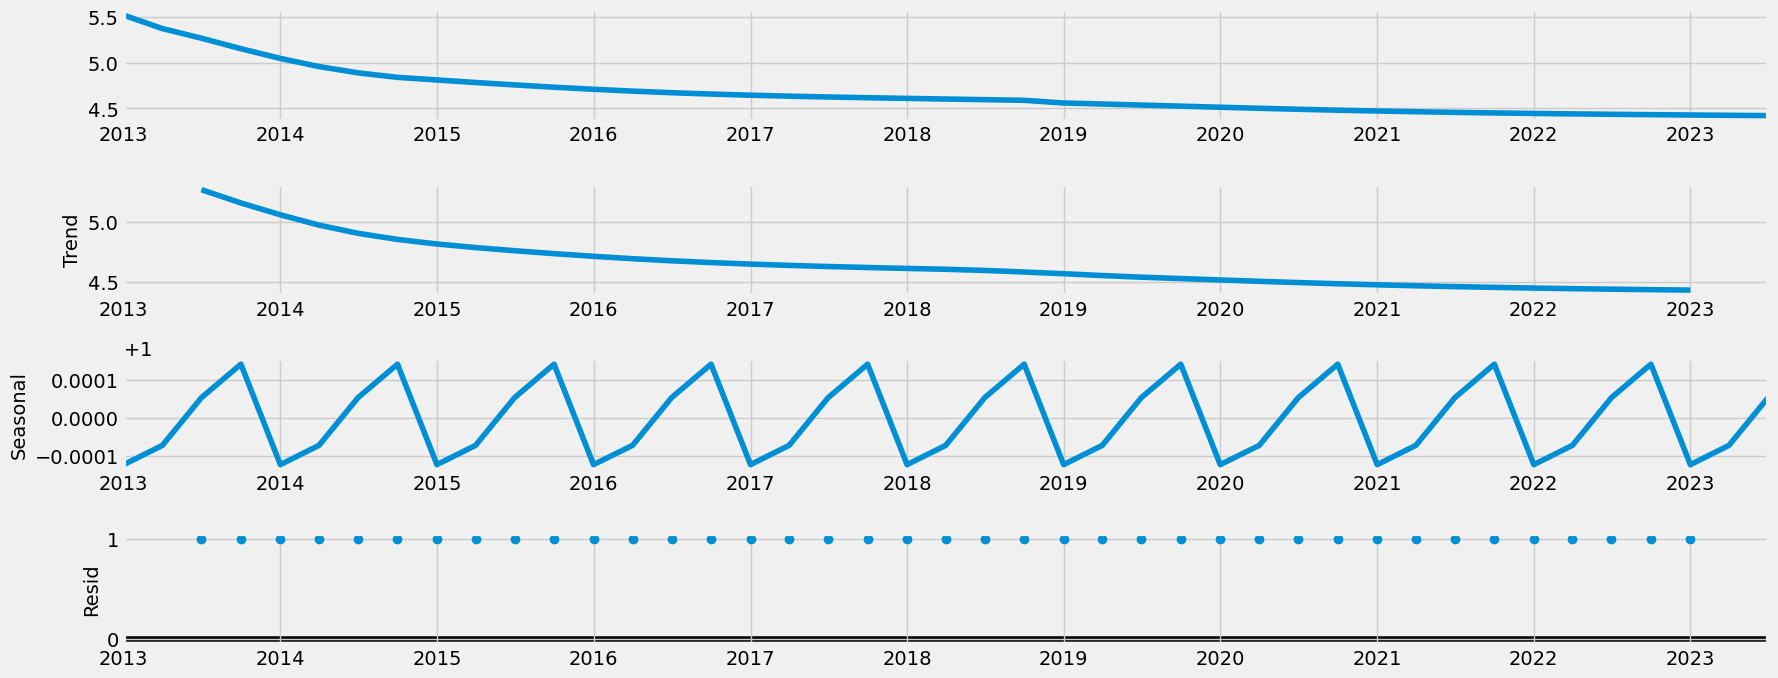

In [34]:
# Plot the separate components
decomposition.plot()
plt.show()

### 4. Testing for stationarity

In [35]:
from statsmodels.tsa.stattools import adfuller # Import the adfuller() function

def dickey_fuller(timeseries): # Define the function
    # Perform the Dickey-Fuller test:
    print ('Dickey-Fuller Stationarity test:')
    test = adfuller(timeseries, autolag='AIC')
    result = pd.Series(test[0:4], index=['Test Statistic','p-value','Number of Lags Used','Number of Observations Used'])
    for key,value in test[4].items():
       result['Critical Value (%s)'%key] = value
    print (result)

# Apply the test using the function on the time series
dickey_fuller(data_sub['Value'])

Dickey-Fuller Stationarity test:
Test Statistic                 -2.103823
p-value                         0.242980
Number of Lags Used             1.000000
Number of Observations Used    41.000000
Critical Value (1%)            -3.600983
Critical Value (5%)            -2.935135
Critical Value (10%)           -2.605963
dtype: float64


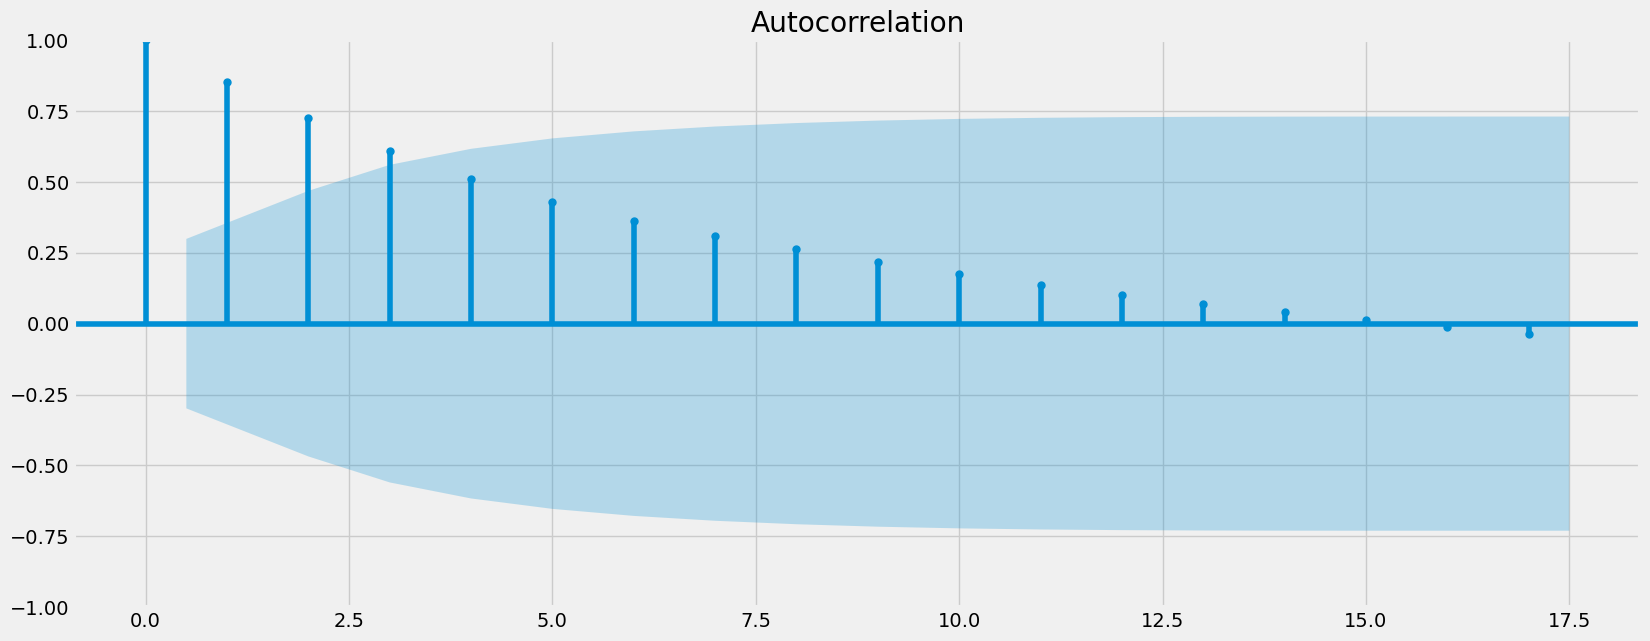

In [36]:
#Plot of autocorrelations

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf 
plot_acf(data_sub)
plt.show()

### 4.0 Stationarizing the Data

In [37]:
data_diff = data_sub - data_sub.shift(1) 

In [38]:
data_diff.dropna(inplace = True)

In [39]:
data_diff.head()

,Value
datetime,
2013-04-01,-0.146310
2013-07-01,-0.104600
2013-10-01,-0.114993
2014-01-01,-0.105884
2014-04-01,-0.088491


In [40]:
data_diff.columns

Index(['Value'], dtype='object')

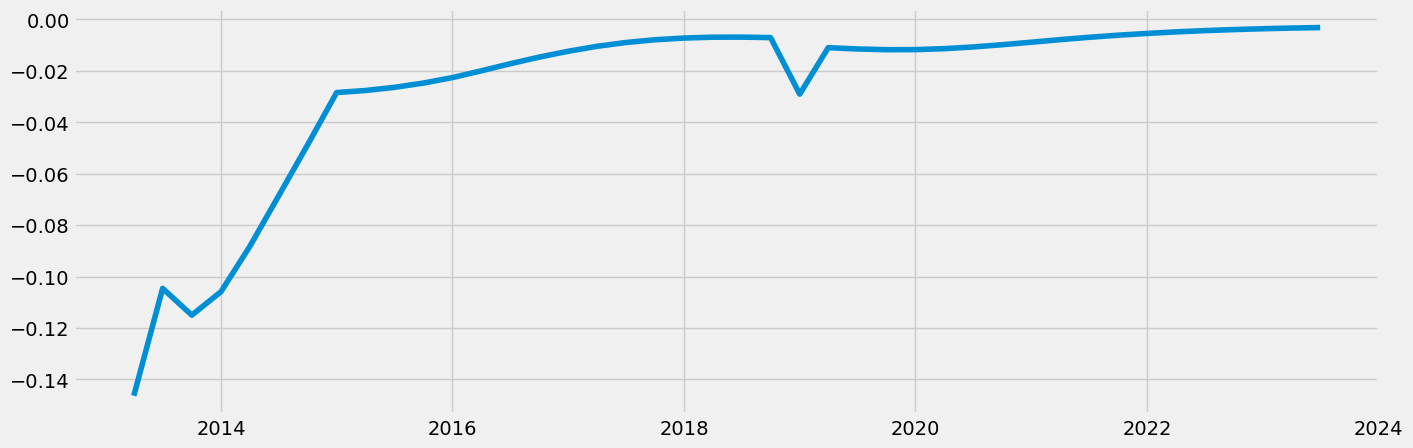

In [41]:
#Plot after differencing
plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_diff)

In [42]:
dickey_fuller(data_diff)
#Test Statistic is now smaller than all critical values, proving that the data is stationary

Dickey-Fuller Stationarity test:
Test Statistic                 -3.808596
p-value                         0.002821
Number of Lags Used             1.000000
Number of Observations Used    40.000000
Critical Value (1%)            -3.605565
Critical Value (5%)            -2.937069
Critical Value (10%)           -2.606986
dtype: float64


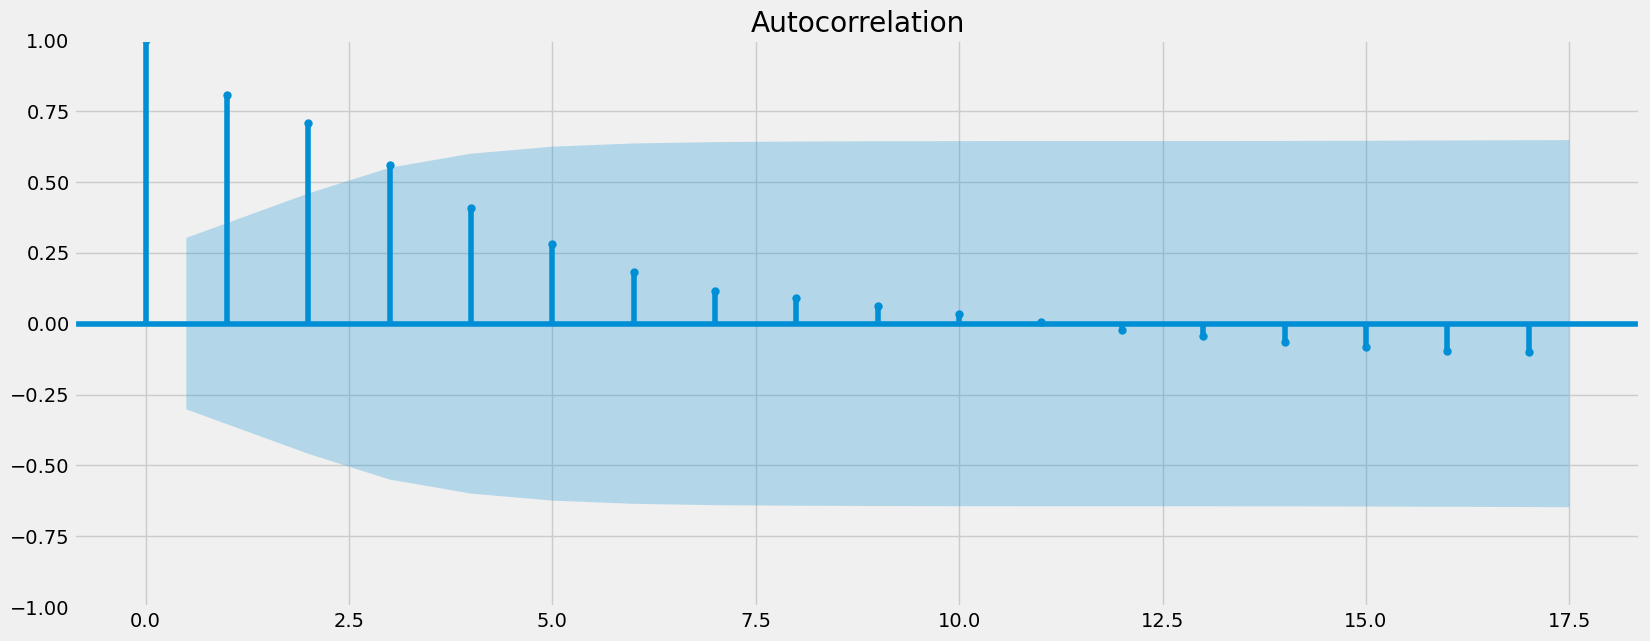

In [43]:
plot_acf(data_diff)
plt.show()
# Well there are still some lags greater than the confidence variable, there are few, making this a stationary dataplot